In [48]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    

def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,6),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")
        

Text(0.5, 1.0, 'Correlated Random Variables')

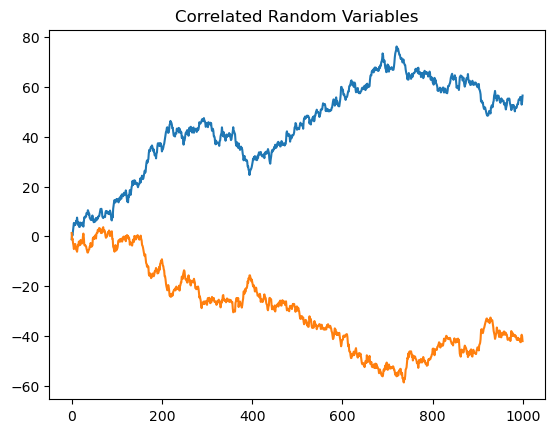

In [49]:
import numpy as np
import matplotlib.pyplot as plt

rho = -0.7
Ndraws = 1000
mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])

W = np.random.multivariate_normal(mu, cov, size=Ndraws)

plt.plot(W.cumsum(axis=0))
plt.title('Correlated Random Variables')

In [50]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi,
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0, 0]),
                                           cov=np.array([[1, rho],
                                                         [rho, 1]]),
                                           size=paths) * np.sqrt(dt)

        S_t = S_t*(np.exp((r - 0.5*v_t)*dt + np.sqrt(v_t) * WT[:, 0]))
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:, 1])
        prices[:, t] = S_t
        sigs[:, t] = v_t

    if return_vol:
        return prices, sigs

    return prices


Text(0, 0.5, 'Density')

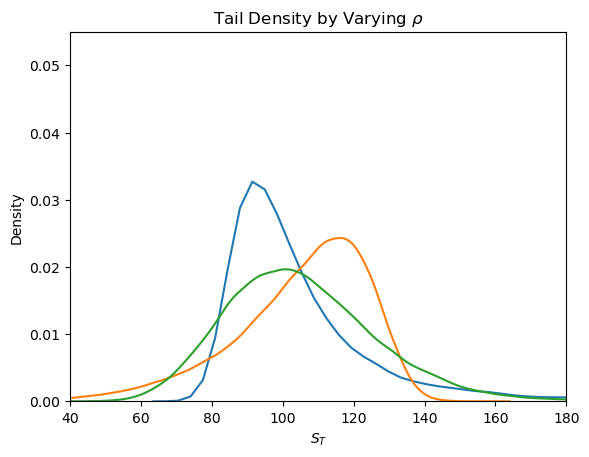

In [54]:
import seaborn as sns
kappa = 3
theta = 0.04
v_0 = 0.04
xi = 0.6
r = 0.05
S = 100
paths = 50000
steps = 2000
T = 1

prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                   v_0, rho=0.9, xi=xi, steps=steps, Npaths=paths,
                                   return_vol=False)[:, -1]
prices_neg = generate_heston_paths(S, T, r, kappa, theta,
                                   v_0, rho=-0.9, xi=xi, steps=steps, Npaths=paths,
                                   return_vol=False)[:, -1]
gbm_bench = S*np.exp(np.random.normal((r - v_0/2)*T,
                                      np.sqrt(theta)*np.sqrt(T), size=paths))


fig, ax = plt.subplots()

ax = sns.kdeplot(data=prices_pos, label=r"$\rho = 0.9$", ax=ax)
ax = sns.kdeplot(data=prices_neg, label=r"$\rho= -0.9$ ", ax=ax)
ax = sns.kdeplot(data=gbm_bench, label="GBM", ax=ax)

ax.set_title(r'Tail Density by Varying $\rho$')
plt.axis([40, 180, 0, 0.055])
plt.xlabel('$S_T$')
plt.ylabel('Density')


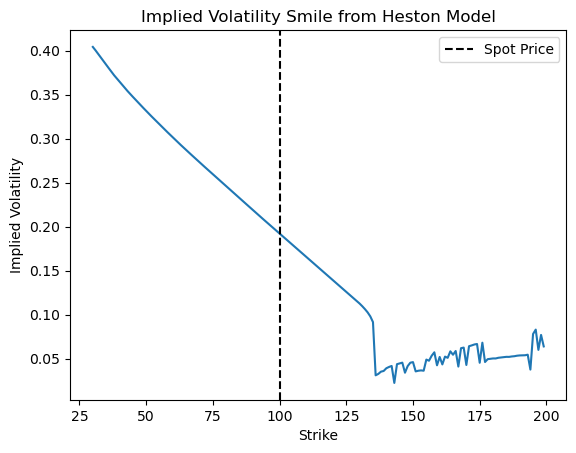

In [55]:

strikes =np.arange(30, 200,1)

puts = [] 

for K in strikes:
    P = np.mean(np.maximum(K-prices_neg,0))*np.exp(-r*T)
    puts.append(P)


ivs = [implied_vol(P, S, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]

plt.plot(strikes, ivs)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S, color='black',linestyle='--',
            label='Spot Price')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()

In [56]:
# kappa = 3
# theta = 0.04
# v_0 = 0.04
# xi = 0.6
# r = 0.05
# S = 100
# paths = 3
# steps = 10000
# T = 1
rho = -0.8

prices, sigs = generate_heston_paths(S, T, r, kappa, theta,
                                     v_0, rho, xi, steps, paths,
                                     return_vol=True)

plt.figure(figsize=(7, 6))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(7, 6))
plt.plot(np.sqrt(sigs).T)
plt.axhline(np.sqrt(theta), color='black', label=r'$\sqrt{\theta}$')
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend(fontsize=15)
plt.show()
